## Using CNN for radiomics study

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pydicom
from pydicom.data import get_testdata_file, get_testdata_files
from pydicom.filereader import read_dicomdir
import pydicom_seg
from skimage.draw import polygon

import os
import sys
import glob

#import tensorflow as tf
#import keras

Plan of attack:

1. Load DICOM images with segmentation as mask
2. Remove everything outside the mask
3. Set up neural network and pass it through

### Loading DICOM images

In [3]:
os.chdir('/Volumes/Time Machine Backups/Radiomics-NSCLC-v3/NSCLC-Radiomics/')
os.chdir('LUNG1-001/09-18-2008-StudyID-69331/0-82046')

In [4]:
# load the DICOM files
files = []

for fname in os.listdir():
    print("loading: {}".format(fname))
    files.append(pydicom.dcmread(fname))

print("file count: {}".format(len(files)))

loading: 000000.dcm
loading: 000001.dcm
loading: 000002.dcm
loading: 000003.dcm
loading: 000004.dcm
loading: 000005.dcm
loading: 000006.dcm
loading: 000007.dcm
loading: 000008.dcm
loading: 000009.dcm
loading: 000010.dcm
loading: 000011.dcm
loading: 000012.dcm
loading: 000013.dcm
loading: 000014.dcm
loading: 000015.dcm
loading: 000016.dcm
loading: 000017.dcm
loading: 000018.dcm
loading: 000019.dcm
loading: 000020.dcm
loading: 000021.dcm
loading: 000022.dcm
loading: 000023.dcm
loading: 000024.dcm
loading: 000025.dcm
loading: 000026.dcm
loading: 000027.dcm
loading: 000028.dcm
loading: 000029.dcm
loading: 000030.dcm
loading: 000031.dcm
loading: 000032.dcm
loading: 000033.dcm
loading: 000034.dcm
loading: 000035.dcm
loading: 000036.dcm
loading: 000037.dcm
loading: 000038.dcm
loading: 000039.dcm
loading: 000040.dcm
loading: 000041.dcm
loading: 000042.dcm
loading: 000043.dcm
loading: 000044.dcm
loading: 000045.dcm
loading: 000046.dcm
loading: 000047.dcm
loading: 000048.dcm
loading: 000049.dcm


In [5]:
# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))

skipped, no SliceLocation: 0


In [6]:
# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

In [7]:
# pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

In [8]:
print(f'Pixel Spacing: {ps}; Slice Thickness: {ss}')

Pixel Spacing: [0.9765625, 0.9765625]; Slice Thickness: 3


In [9]:
print(f'Aspects for axial, sagittal and coronal: {ax_aspect}, {sag_aspect}, {cor_aspect}')

Aspects for axial, sagittal and coronal: 1.0, 0.3255208333333333, 3.072


In [10]:
# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

In [11]:
# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

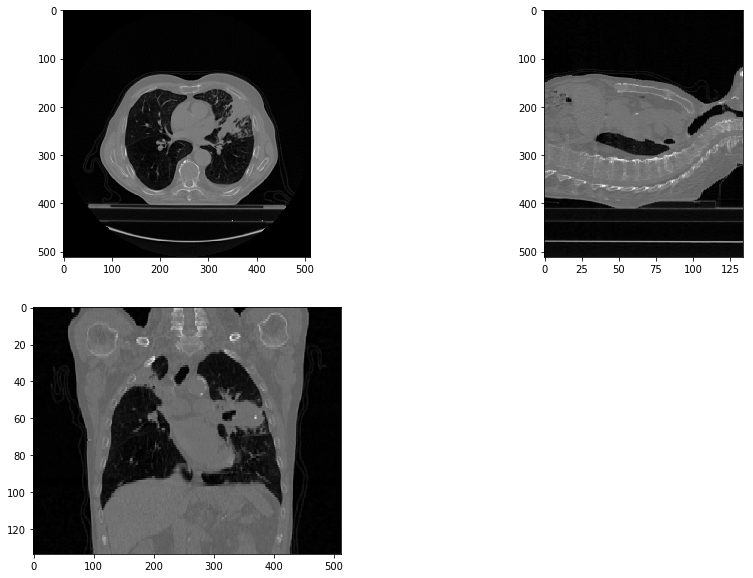

In [12]:
# plot 3 orthogonal slices
plt.figure(figsize=(15,10))
plt.gray()

a1 = plt.subplot(2, 2, 1)
plt.imshow(img3d[:, :, img_shape[2]//2])
a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
plt.imshow(img3d[:, img_shape[1]//2, :])
a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 3)
plt.imshow(img3d[img_shape[0]//2, :, ::-1].T) #-1 to flip the SI directions
a3.set_aspect(cor_aspect)

plt.show()

The DICOM images seem to have been loaded correctly. We should now look at the mask.

In [13]:
os.getcwd()

'/Volumes/Time Machine Backups/Radiomics-NSCLC-v3/NSCLC-Radiomics/LUNG1-001/09-18-2008-StudyID-69331/0-82046'

In [14]:
dcm = pydicom.dcmread('../../02-25-2019-CTLUNG-69331/300-Segmentation-64821/000000.dcm')

reader = pydicom_seg.MultiClassReader()
result = reader.read(dcm)

image_data = result.data  # directly available
image = result.image  # lazy construction

DICOM-SEG does not specify "(0062, 0013) SegmentsOverlap", assuming UNDEFINED and checking pixels


Look at the shape of the array:

In [15]:
image_data.shape

(134, 512, 512)

How does this compare to the shape of the array of the CT image series:

In [16]:
img_shape

[512, 512, 134]

Visualize the mask at the middle:

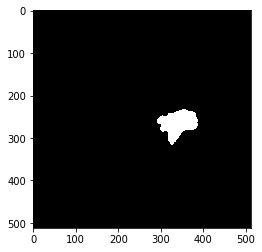

In [17]:
plt.imshow(image_data[image_data.shape[0]//2+7, :, :])

This seems to show the axial slice. The L-R and A-P directions seem to be consistent with the CT image from before.

Now show different slices of the mask:

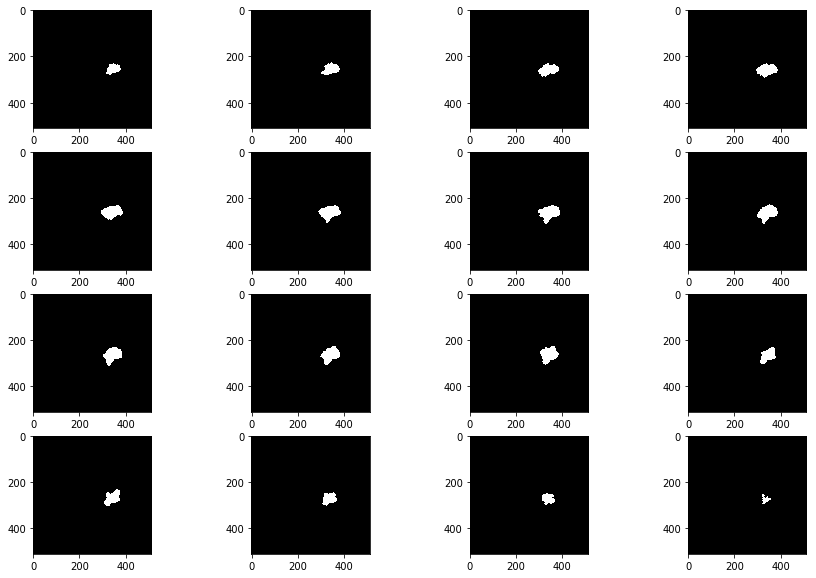

In [18]:
plt.figure(figsize=(15,10))

for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(image_data[image_data.shape[0]//2+i, :, :])

plt.show()

I then compared with the images on 3D Slicer GUI. As the index increases, the slice seems to move towards the superior direction (i.e. towards the head).

But what if there is more than one GTV (i.e. more than one tumour)?

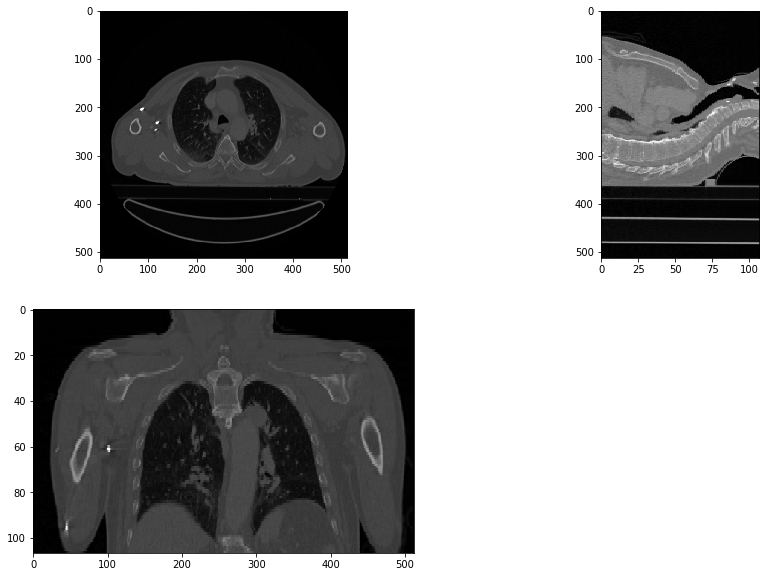

In [19]:
os.chdir('/Volumes/Time Machine Backups/Radiomics-NSCLC-v3/NSCLC-Radiomics/')
os.chdir('LUNG1-003/01-01-2014-StudyID-34270/1-28595/')

# load the DICOM files
files = []

for fname in os.listdir():
    files.append(pydicom.dcmread(fname))
    
# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1
        
# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

# pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d
    
# plot 3 orthogonal slices
plt.figure(figsize=(15,10))
plt.gray()

a1 = plt.subplot(2, 2, 1)
plt.imshow(img3d[:, :, img_shape[2]//2])
a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
plt.imshow(img3d[:, img_shape[1]//2, :])
a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 3)
plt.imshow(img3d[img_shape[0]//2, :, ::-1].T) #-1 to flip the SI directions
a3.set_aspect(cor_aspect)

plt.show()

Now the mask:

In [20]:
dcm = pydicom.dcmread('../../02-25-2019-CTLUNG-34270/300-Segmentation-72932/000000.dcm')

reader = pydicom_seg.MultiClassReader()
result = reader.read(dcm)

image_data = result.data  # directly available
image = result.image  # lazy construction

DICOM-SEG does not specify "(0062, 0013) SegmentsOverlap", assuming UNDEFINED and checking pixels


In [21]:
result.segment_infos

{1: (0008, 2218)  Anatomic Region Sequence   1 item(s) ---- 
    (0008, 0100) Code Value                          SH: 'T-28000'
    (0008, 0102) Coding Scheme Designator            SH: 'SRT'
    (0008, 0104) Code Meaning                        LO: 'Lung'
    ---------
 (0062, 0003)  Segmented Property Category Code Sequence   1 item(s) ---- 
    (0008, 0100) Code Value                          SH: 'M-01000'
    (0008, 0102) Coding Scheme Designator            SH: 'SRT'
    (0008, 0104) Code Meaning                        LO: 'Morphologically Altered Structure'
    ---------
 (0062, 0004) Segment Number                      US: 1
 (0062, 0005) Segment Label                       LO: 'Neoplasm, Primary'
 (0062, 0006) Segment Description                 ST: 'GTV-1'
 (0062, 0008) Segment Algorithm Type              CS: 'MANUAL'
 (0062, 000d) Recommended Display CIELab Value    US: [43803, 26565, 37722]
 (0062, 000f)  Segmented Property Type Code Sequence   1 item(s) ---- 
    (0008, 0100) 

It seems the segmentation file only registers one GTV. The structure tree displayed in 3D Slicer confirms this.
What if we look at the RTSTRUCT dicome file instead? It is also contained in the '...CTLUNG...' folder.

In [22]:
dcm = pydicom.dcmread('../../02-25-2019-CTLUNG-34270/4-22712/000000.dcm')

In [23]:
print(dcm.StructureSetROISequence)

[(3006, 0022) ROI Number                          IS: "5"
(3006, 0024) Referenced Frame of Reference UID   UI: 1.3.6.1.4.1.32722.99.99.206778463430509708547258646438473724055
(3006, 0026) ROI Name                            LO: 'Lung-Right'
(3006, 0028) ROI Description                     ST: 'Lung R'
(3006, 0036) ROI Generation Algorithm            CS: 'MANUAL'(3006, 0022) ROI Number                          IS: "6"
(3006, 0024) Referenced Frame of Reference UID   UI: 1.3.6.1.4.1.32722.99.99.206778463430509708547258646438473724055
(3006, 0026) ROI Name                            LO: 'Lung-Left'
(3006, 0028) ROI Description                     ST: 'Lung L'
(3006, 0036) ROI Generation Algorithm            CS: 'MANUAL'(3006, 0022) ROI Number                          IS: "7"
(3006, 0024) Referenced Frame of Reference UID   UI: 1.3.6.1.4.1.32722.99.99.206778463430509708547258646438473724055
(3006, 0026) ROI Name                            LO: 'Heart'
(3006, 0028) ROI Description           

The question now is how to select only the GTVs for processing?

The snippet below will:
- retrieve all ROIs with GTV as part of the description name
- grab the contour information for each GTV

In [24]:
gtv_structures = []
gtv_contour = []

for i, roi in enumerate(dcm.StructureSetROISequence):
    if ("gtv" in roi.ROIDescription.lower()):
        gtv_structures.append(roi)
        
        # Check to make sure the ROI number matches
        assert roi.ROINumber == dcm.ROIContourSequence[i].ReferencedROINumber
            
        gtv_contour.append(s.ContourData for s in dcm.ROIContourSequence[i].ContourSequence)

OKay they work. Define two functions:
(Source: http://aapmchallenges.cloudapp.net/forums/3/2/)

In [34]:
def read_structure(structure):
    contours = []
    
    for i in range(len(structure.ROIContourSequence)):
        
        # Only include GTVs
        if ("gtv" not in structure.StructureSetROISequence[i].ROIDescription.lower()):
            continue
        
        contour = {}
        contour['number'] = structure.ROIContourSequence[i].ReferencedROINumber
        contour['name'] = structure.StructureSetROISequence[i].ROIName
        assert contour['number'] == structure.StructureSetROISequence[i].ROINumber
        contour['contours'] = [s.ContourData for s in structure.ROIContourSequence[i].ContourSequence]
        contours.append(contour)
        
    return contours

In [29]:
def get_mask(contours, slices):
    z = [s.ImagePositionPatient[2] for s in slices]
    pos_r = slices[0].ImagePositionPatient[1]
    spacing_r = slices[0].PixelSpacing[1]
    pos_c = slices[0].ImagePositionPatient[0]
    spacing_c = slices[0].PixelSpacing[0]

    label = np.zeros_like(image, dtype=np.uint8)
    
    for con in contours:
        num = int(con['number'])
        
        for c in con['contours']:
            
            nodes = np.array(c).reshape((-1, 3))
            assert np.amax(np.abs(np.diff(nodes[:, 2]))) == 0
            z_index = z.index(nodes[0, 2])
            r = (nodes[:, 1] - pos_r) / spacing_r
            c = (nodes[:, 0] - pos_c) / spacing_c
            rr, cc = polygon(r, c)
            label[rr, cc, z_index] = num

        colors = tuple(np.array([con['color'] for con in contours]) / 255.0)
    return label, colors

In [35]:
train_data_path = "/Volumes/Time Machine Backups/Radiomics-NSCLC-v3/NSCLC-Radiomics/LUNG1-001"
train_patients = [os.path.join(train_data_path, name) 
                  for name in os.listdir(train_data_path) if os.path.isdir(os.path.join(train_data_path, name))]

patient = train_patients[0] # Just get the first patient for demo
for subdir, dirs, files in os.walk(patient):
    dcms = glob.glob(os.path.join(subdir, "*.dcm"))
    if len(dcms) == 1:
        structure = pydicom.read_file(os.path.join(subdir, files[0]))
        contours = read_structure(structure)
    elif len(dcms) > 1:
        slices = [dicom.read_file(dcm) for dcm in dcms]
        slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
        image = np.stack([s.pixel_array for s in slices], axis=-1)
        label, colors = get_mask(contours, slices)

# Plot to check slices, for example 50 to 59
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image[..., i + 50], cmap="gray")
    plt.contour(label[..., i + 50], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors=colors)
    plt.axis('off')

AttributeError: 'FileDataset' object has no attribute 'ROIContourSequence'